In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # High quality graphics
plt.rcParams['animation.html'] = 'html5'

import sys
import time

In [2]:
# Time step progress bar
def update_progress_bar(current, total):
    sys.stdout.write('\rTime step: [{:<50}] {:.0f}/{:.0f} ({:.2f}%)'.format('=' * int(current/total * 50), current, total, current*100/total))
    sys.stdout.flush()

As part of the Finite Volume Method, a negative staggered grid shall be followed to align with the natural indexing of Python. That is, for a stuctured grid as in this example, the system is followed as in diagram which contains the scalar control volume, x-momentum control volume and the y momentum control volume, with p, u and v centred at respective volumes.

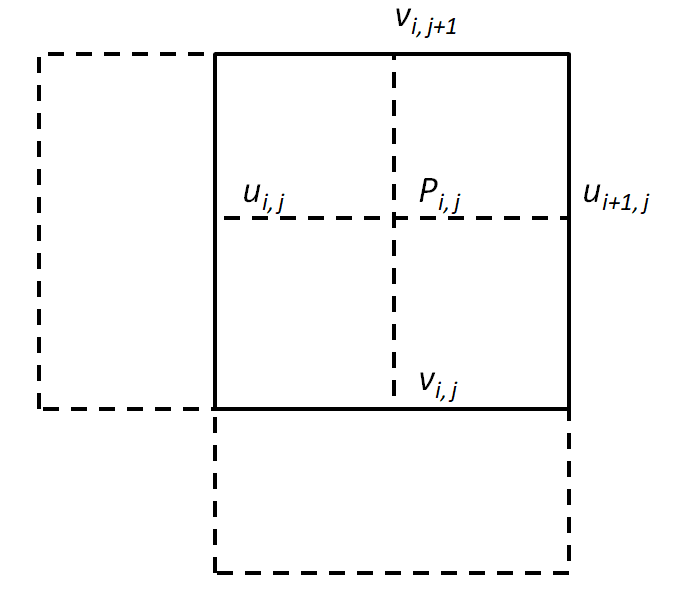

For this grid system the governing equations are discretized. The integral forms of continuity, x and y momentum equations are:

$$ \int \textbf{u}\cdot\mathbf{\hat n}dS = 0$$
$$ \frac{\partial}{\partial t}\int u dV = -\int u\textbf{u}\cdot \mathbf{\hat n}dS + \nu\int\nabla u\cdot\mathbf{\hat n}dS - \frac{1}{\rho}\int p\cdot n_x dS$$
$$ \frac{\partial}{\partial t}\int v dV = -\int v\textbf{u}\cdot \mathbf{\hat n}dS + \nu\int\nabla v\cdot\mathbf{\hat n}dS - \frac{1}{\rho}\int p\cdot n_y dS$$

For discretization, the mid-point rule is used. Continuity is evaluated at the scalar volume, x-momentum at x-momentum control volume and the y-momentum in y-momentum control volume. The **continuity** becomes:
$$\frac{u_\text{i+1, j}^\text{n+1} - u_\text{i, j}^\text{n+1}}{\Delta x} + \frac{v_\text{i, j+1}^\text{n+1} - v_\text{i, j}^\text{n+1}}{\Delta y} = 0$$

**Convective flux of x-momentum** becomes:
$$\approx \sum_f u_f\textbf{u}_f\cdot \textbf{n}_fS_f$$

where f are the east, west, north and southern faces of the x-momentum control volume, which are located at the scalar volume centres. By applying the face normals:
$$\left[(uu)_e-(uu)_w\right]\Delta y + \left[(uv)_n-(uv)_s\right]\Delta x$$

where, using the second order accurate Taylor's series, each of the term equals:
$$u_e \approx \frac{u_{i+1, j}+u_{i, j}}{2}\qquad u_w \approx \frac{u_{i-1, j}+u_{i, j}}{2} \qquad u_n \approx \frac{u_{i, j+1}+u_{i, j}}{2} \qquad u_s \approx \frac{u_{i, j-1}+u_{i, j}}{2}$$
$$v_n \approx \frac{v_{i, j+1}+v_{i-1, j+1}}{2} \qquad v_s \approx \frac{v_{i, j}+v_{i-1, j}}{2}$$

**Diffusive flux of x-momentum** becomes:
$$\approx \sum_f (\Delta u)_f \cdot \mathbf{n}_fS_f = \left[\left(\frac{\partial u}{\partial x}\right)_e - \left(\frac{\partial u}{\partial x}\right)_w\right]\Delta y + \left[\left(\frac{\partial u}{\partial y}\right)_n - \left(\frac{\partial u}{\partial y}\right)_s\right]\Delta x$$

Using second order approximation:
$$\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta x}\Delta y + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta y}\Delta x$$

**Pressure Gradient term** of the **x-momentum** centred in x-momentum control volume is:
$$\approx \sum_f p_f\cdot n_{xf}S_f = (p_{i,j} - p_{i-1, j})\Delta y$$

Similarly, it is discetized for the **y-momentum** as well.

For implementing boundary conditions, ghost cells are used. Pressure BCs are derived from the continuity equation and the equation for predictor velocity from the Pressure projection method.

$$\frac{\partial\widetilde{\textbf{u}}}{\partial t} = -\textbf{A} + \textbf{D}$$


$$\frac{\widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} - \textbf{u}_{\text{i,j}}^{\text{n}}}{\Delta t} = -\textbf{A}_{\text{i,j}}^{\text{n}} + \textbf{D}_{\text{i,j}}^{\text{n}}$$


$$\frac{\textbf{u}_{\text{i,j}}^{\text{n+1}} - \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}}}{\Delta t} = -\frac{\nabla p_{i, j}}{\rho}$$

$$div\ \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} = \frac{\Delta t}{\rho}\nabla^2p $$

In [3]:
# All normal velocity components are 0 - since all are "walls", no inlets
ut = 1 # Top wall velocity
ub = 0 # Bottom wall velocity
vl = 0 # Left wall velocity
vr = 0 # Right wall velocity

tf = 1 # Total time of simulation.
ν = 0.05 # Kinematic viscosity of fluid
ρ = 1 # Density of fluid

nx = 32 # Grid points along x
ny = 32 # Grid points along y
Lx = 1 # Length of domain along x
Ly = 1 # Length of domain along y
dx = Lx/nx
dy = Ly/ny

print(f'Reynolds number = {ut*Lx/ν}')
print(f'\nMinimum required time step: {min(0.25*(min(dx, dy)**2)/ν, (4*ν)/(ut*ut))}s')
dt = min(0.25*(min(dx, dy)**2)/ν, (4*ν)/(ut*ut))/2
ts = math.ceil(tf/dt)
dt = tf/ts
print(f'Selected time step = {dt}s\nTotal number of time steps = {ts}')
print(f'\nStability Criteria 1 (0.25: dimensionless): {(ν*dt)/(min(dx, dy)**2) < 0.25} ({(ν*dt)/(min(dx, dy)**2)})')
print(f'Stability Criteria 2 (4: dimensionless): {(ut*ut*dt)/ν < 4} ({(ut*ut*dt)/ν})')

Reynolds number = 20.0

Minimum required time step: 0.0048828125s
Selected time step = 0.0024390243902439024s
Total number of time steps = 410

Stability Criteria 1 (0.25: dimensionless): True (0.1248780487804878)
Stability Criteria 2 (4: dimensionless): True (0.048780487804878044)


In [4]:
# Initialise velocities and pressure as zeroes
# (ny+2, nx+2) shape to include ghost cells
# Staggered grid to the minus side

u_0 = np.zeros([ny+2, nx+2])
v_0 = np.zeros([ny+2, nx+2])
p_0 = np.zeros([ny+2, nx+2])
p_rhs = np.zeros([ny+2, nx+2])

# The predictor velocities are separately initialised. Does not have the same BC as correctors
u_p = np.zeros([ny+2, nx+2])
v_p = np.zeros([ny+2, nx+2])

u_sol, v_sol, p_sol = [], [], []
u_sol.append(u_0)
v_sol.append(v_0)
p_sol.append(p_0)

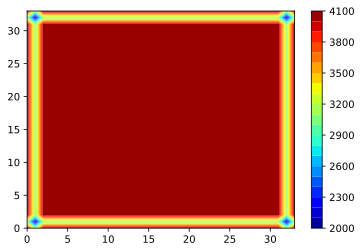

In [5]:
# Pressure-Poisson equation pressure coefficients
# HAS to be shape (ny+2, nx+2) if you want to use same indexing within loops, even though ghost cell coeff.s don't matter here
Ap = np.zeros([ny+2, nx+2])
Ae = np.ones([ny+2, nx+2])*(1/(dx*dx))
Aw = np.ones([ny+2, nx+2])*(1/(dx*dx))
An = np.ones([ny+2, nx+2])*(1/(dy*dy))
As = np.ones([ny+2, nx+2])*(1/(dy*dy))

# Set coefficients at boundaries (interior i and js only)
Aw[:, 1] = 0 # Left boundary
Ae[:, -2] = 0 # Right boundary
An[-2, :] = 0 # Top boundary
As[1, :] = 0 # Bottom boundary

Ap = -(Aw + Ae + An + As)

# Just plot a contour to confirm. -Ap should be lowest at corners, then at boundaries, and max at interior cells
plt.figure(figsize = (6, 4))
plt.contourf(-Ap, cmap = plt.cm.jet, levels = 20)
plt.colorbar()
plt.show()

In [6]:
# PPE Solver
def ppe_OR_solver(p_k1, b):
    '''Pressure-Poisson solver. Requires the RHS of PPE [(ρ/dt)*div(u_tilde)] and the latest pressure solution'''
    it = 0
    err = 1000
    ϵ = 1e-8
    max_itr = 100
    β = 1.1
    
    while err > ϵ and it < max_itr:
        p_k = p_k1.copy()
        for i in range(1, nx+1):
            for j in range(1, ny+1):
                prhs = b[j, i] - (Ae[j, i]*p_k1[j, i+1] + Aw[j, i]*p_k1[j, i-1] + An[j, i]*p_k1[j+1, i] + As[j, i]*p_k1[j-1, i])
                p_k1[j, i] = β*(prhs/Ap[j, i]) + (1 - β)*p_k1[j, i]
        err = np.linalg.norm(p_k1 - p_k, 2)
        it += 1
    return p_k1, err

In [7]:
start = time.time()
t = 0
while t < tf:
    u_n = u_sol[-1]
    v_n = v_sol[-1]
    p_n = p_sol[-1]
    
    # Boundary conditions of u
    u_n[:, 1] = 0 # Left wall
    u_n[:, -1] = 0 # Right wall
    u_n[-1, :] = 2*ut - u_n[-2, :] # Top wall ghost cell
    u_n[0, :] = 2*ub - u_n[1, :] # Bottom wall ghost cell 
    
    # Boundary conditions of v
    v_n[-1, :] = 0 # Top wall
    v_n[1, :] = 0 # Bottom wall
    v_n[:, 0] = 2*vl - v_n[:, 1] # Left wall ghost cell
    v_n[:, -1] = 2*vr - v_n[:, -2] # Right wall ghost cell
    
    u_n1 = u_n.copy()
    v_n1 = v_n.copy()
    
    # Predictor step
    # x-momentum for u-predictor; loop over u-CV; Interior points only ([2, nx], [1, ny])
    for i in range(2, nx+1):
        for j in range(1, ny+1):
            u_ea = 0.5*(u_n[j, i+1] + u_n[j, i])
            u_we = 0.5*(u_n[j, i] + u_n[j, i-1])
            u_no = 0.5*(u_n[j, i] + u_n[j+1, i])
            u_so = 0.5*(u_n[j, i] + u_n[j-1, i])
            v_no = 0.5*(v_n[j+1, i] + v_n[j+1, i-1])
            v_so = 0.5*(v_n[j, i] + v_n[j, i-1])
            conv = -(u_ea*u_ea - u_we*u_we)/dx - (u_no*v_no - u_so*v_so)/dy
            diff = ν*((u_n[j, i+1] - 2*u_n[j, i] + u_n[j, i-1])/(dx*dx) + (u_n[j+1, i] - 2*u_n[j, i] + u_n[j-1, i])/(dy*dy))
            u_p[j, i] = (conv + diff)*dt + u_n[j, i]
    
    # y-momentum for v-predictor; loop over v-CV; Interior points only ([1, nx], [2, ny])
    for i in range(1, nx+1):
        for j in range(2, ny+1):
            v_ea = 0.5*(v_n[j, i] + v_n[j, i+1])
            v_we = 0.5*(v_n[j, i] + v_n[j, i-1])
            v_no = 0.5*(v_n[j, i] + v_n[j+1, i])
            v_so = 0.5*(v_n[j, i] + v_n[j-1, i])
            u_we = 0.5*(u_n[j, i] + u_n[j-1, i])
            u_ea = 0.5*(u_n[j, i+1] + u_n[j-1, i+1])
            conv = -(u_ea*v_ea - u_we*v_we)/dx - (v_no*v_no - v_so*v_so)/dy
            diff = ν*((v_n[j, i+1] - 2*v_n[j, i] + v_n[j, i-1])/(dx*dx) + (v_n[j+1, i] - 2*v_n[j, i] + v_n[j-1, i])/(dy*dy))
            v_p[j, i] = (conv + diff)*dt + v_n[j, i]
    
    # Solve the PPE
    # RHS: Looped over the scaler-CV; Interior points only ([1, nx], [1,ny])
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            p_rhs[j, i] = (u_p[j, i+1] - u_p[j, i])/dx + (v_p[j+1, i] - v_p[j, i])/dy
    p_rhs /= dt
    p_n1, err_ = ppe_OR_solver(p_n, p_rhs)

    # Corrector step
    # Only interior points of velocity. Accordingly slice p[j, i+1] etc.
    u_n1[1:-1, 2:-1] = u_p[1:-1, 2:-1] - (dt/(ρ*dx))*(p_n1[1:-1, 2:-1] - p_n1[1:-1, 1:-2])
    v_n1[2:-1, 1:-1] = v_p[2:-1, 1:-1] - (dt/(ρ*dx))*(p_n1[2:-1, 1:-1] - p_n1[1:-2, 1:-1])
    
    # Store to solution list
    u_sol.append(u_n1)
    v_sol.append(v_n1)
    p_sol.append(p_n1)
    
    time.sleep(dt)
    t+=dt
    progress = t / tf  # Calculate progress as a percentage
    update_progress_bar(int(t/dt), ts)

update_progress_bar(ts, ts)
end = time.time() - start
print(f'\nTime taken for simulation: {round(end, 3)}s')

Time step: [==================================================] 410/410 (100.00%)
Time taken for simulation: 140.459s


- Make sure the terms are right. Took a long time debugging a simple error for the coefficient of pressures at the corrector step, where I used $\rho/\Delta t$ instead of $\Delta t/\rho$, which lead to values of velocities overshooting to infinity
- Simulation is taking longer than the FDM solver. For the same Poisson-solver tolerance, boundary conditions and fluid, and even with over-relaxation it took over 100% time for the FVM solver. Here, I have reduced the tolerance further, and is taking considerable amount of time. Perhaps scarse iterative solvers need to be used

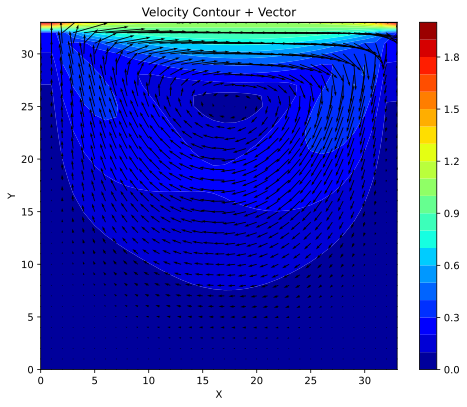

In [8]:
width = 8
frame = -1
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
cont = ax.contourf(np.sqrt(u_sol[-1]**2 + v_sol[-1]**2), cmap = plt.cm.jet, levels = 20)
ax.quiver(u_sol[frame], v_sol[frame], scale=5)
plt.colorbar(cont, ax=ax)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Contour + Vector')
# ax.set(xlim = [1, nx-1], ylim = [1, ny-1]
plt.show()

# plt.figure(figsize = (6, 6))
# plt.contourf(np.sqrt(u_p**2 + v_p**2), cmap = plt.cm.jet, levels = 20)
# plt.quiver(u_sol[-1], v_sol[-1], scale=5)
# plt.xlim([1, nx-1])
# plt.ylim([1, ny-1])

Solution without the corrector step. Again, no conservation of mass

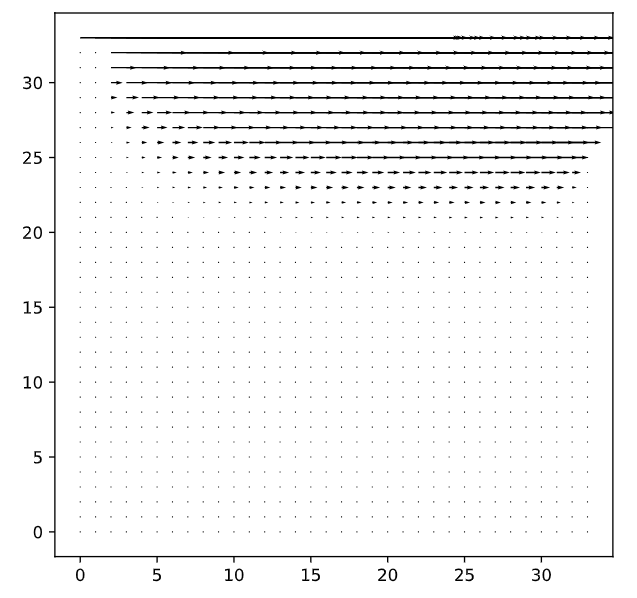

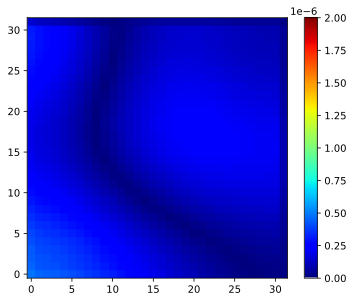

In [9]:
u_f = u_sol[-1]
v_f = v_sol[-1]
div_u = (u_f[1:-1, 2:] - u_f[1:-1, 1:-1])/dx + (v_f[2:, 1:-1] - v_f[1:-1, 1:-1])/dy
width = 6
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
cont = ax.imshow(abs(div_u), cmap = plt.cm.jet, origin = 'lower', vmin = 0, vmax = 0.000002)
plt.colorbar(cont, ax=ax)
plt.show()

- It can be seen that the divergence of velocity is negligible here unlike the Pressure-Projection Method with FDM solver. This is the inherent property of FVM solver with a staggered grid system, where $div \ \nabla p$ is approximated close to $\nabla^2 p$
- Moreover, the small value of divergence visible is attributed to the minimum tolerance set in the pressure-poisson solver. Remember that,
$$div\ {\textbf{u}}_{\text{i,j}}^{\text{n+1}} = div\ \widetilde{\textbf{u}}_{\text{i,j}}^{\text{n+1}} - \frac{\Delta t}{\rho}\nabla^2p $$

Hence, the order of error in $div\ {\textbf{u}}_{\text{i,j}}^{\text{n+1}}$ is of the same order as error in $nabla^2 p$, which is set in the Pressure-Poisson solver. This is checked below

In [10]:
print(err_)

1.163378239167444e-06


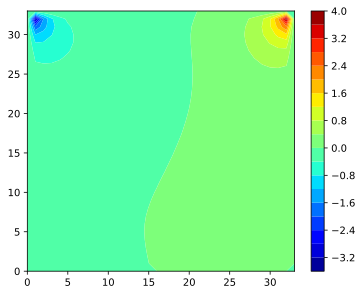

In [11]:
# Pressure contour
width = 6
plt.figure(figsize = (width, (Ly/Lx)*width*0.8))
plt.contourf(p_sol[-1], cmap = plt.cm.jet, levels = 20)
plt.colorbar()
plt.show()

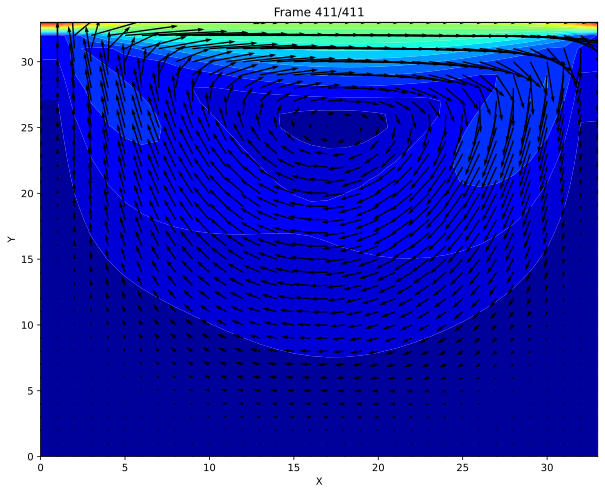

In [12]:
# Vector animation
width = 10
fig, ax = plt.subplots(figsize = (width, (Ly/Lx)*width*0.8))
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.contourf(np.sqrt(u_sol[frame]**2 + v_sol[frame]**2), cmap = plt.cm.jet, levels = 20)
    ax.quiver(u_sol[frame], v_sol[frame], scale=5)
    ax.set(xlabel = 'X', ylabel = 'Y', title = f'Frame {frame + 1}/{len(u_sol)}')

animation = anm.FuncAnimation(fig, update, frames=list(range(0, len(u_sol), int(len(u_sol)/100)))+[len(u_sol)-1], repeat=False)
animation

In [13]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [14]:
animation.save('vector_animation_FVM.gif', writer = 'pillow', fps = 10)

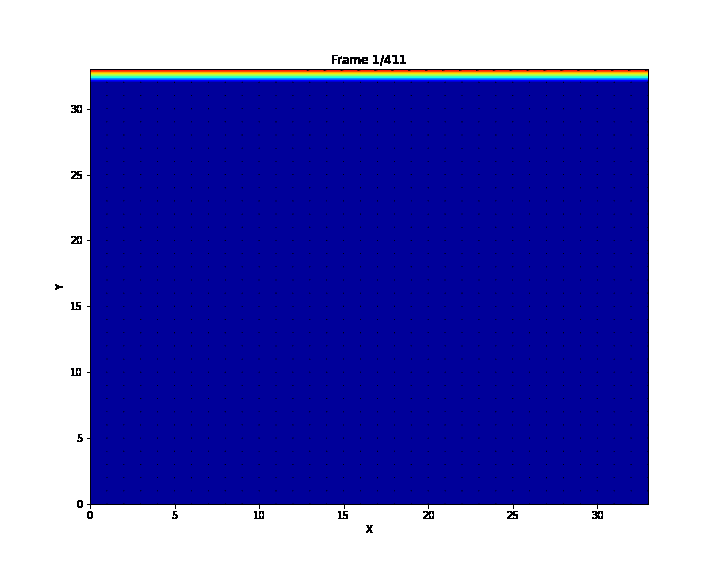

Never forget to use THAT image when you are coding for FVM!!